In [2]:
try:
  import optax
except:
  %pip install -qq optax
  import optax
try:
    from ajax import Prior, Likelihood, Variational, ADVI
except:
   %pip install -qq git+https://github.com/patel-zeel/ajax.git
   from ajax import Prior, Likelihood, Variational, ADVI

try:
  import tensorflow_probability.substrates.jax as tfp
except:
  %pip install -qq tensorflow_probability.substrates.jax
  import tensorflow_probability.substrates.jax as tfp

try:
  import jax.numpy as jnp
except:
  %pip install -qq jax
  import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import pickle
import pandas as pd
tfd = tfp.distributions
tfb = tfp.bijectors
import numpy as np

In [3]:
with open("./logistic_regression_data",'rb') as f:
    data = pickle.load(f)

In [4]:
X = data['data']['x']
X[:,:2] = (X[:,:2]- jax.numpy.min(X,axis = 0)[:2])/(jax.numpy.max(X,axis = 0)[:2]-jax.numpy.min(X, axis = 0)[:2])
mean_prior = data['prior']['loc']
var_prior = data['prior']['covariance_matrix']
Y = jnp.array(data['data']['y'])
Y = jnp.reshape(Y, (Y.shape[1],))

In [5]:
prior = Prior(distributions={"beta":tfd.MultivariateNormalDiag(loc=mean_prior, scale_diag= jnp.diagonal(var_prior))})

In [6]:
def link_function(samples):
    theta = X@samples["beta"]
    probs = jax.nn.sigmoid(theta)
    return {
        'probs' : probs
    }

In [7]:
likelihood = Likelihood(tfd.Bernoulli, link_function)

In [8]:
variational = Variational(
    prior=prior,
    bijectors={"beta":tfb.Identity()},
    vi_type="full_rank"
)

In [9]:
advi = ADVI(prior, likelihood, variational, Y)

In [10]:
params = variational.get_params()
tx = optax.adam(learning_rate=0.1)
state = tx.init(params)
value_and_grad_fun = jax.jit(jax.value_and_grad(advi.loss),static_argnames=['n_samples'])
seed = jax.random.PRNGKey(10)
value_and_grad_fun(params, seed)

(DeviceArray(790.6045, dtype=float32),
 {'beta': <tfp.distributions.TransformedDistribution 'identityMultivariateNormalTriL' batch_shape=[] event_shape=[3] dtype=float32>})

In [11]:
def update_func(carry,x):
  params = carry['params']
  state = carry['state']
  seed = carry['seed']
  seed = jax.random.split(seed, 1)[0]
  loss, grads = value_and_grad_fun(params, seed = seed,n_samples = 10)
  updates, state = tx.update(grads, state)
  loc_m, scale = jax.tree_leaves(variational.transform_dist(params['beta']))
  params = optax.apply_updates(params, updates)
  carry = {'params':params, 'state':state, 'seed':seed}
  di = {"scale":scale, "loc" : loc_m, "loss" : loss,'grads':grads}
  return carry, di

In [12]:
carry = {'params':params, 'state': state,'seed':jax.random.PRNGKey(5)}
n_itr = 600
carry,loss = jax.lax.scan(update_func, carry,xs = None,length = n_itr)

In [13]:
variational.set_params(carry['params'])

In [19]:
loc_m, scale = jax.tree_leaves(variational.transform_dist(carry['params']['beta']))

In [20]:
scale = jnp.dot(scale, scale.T)
scale

DeviceArray([[ 1.3107129 , -0.61637175, -0.32735184],
             [-0.61637175,  0.47308454,  0.07872671],
             [-0.32735184,  0.07872671,  0.12840475]], dtype=float32)

1.3107129
0.47308454
0.12840475


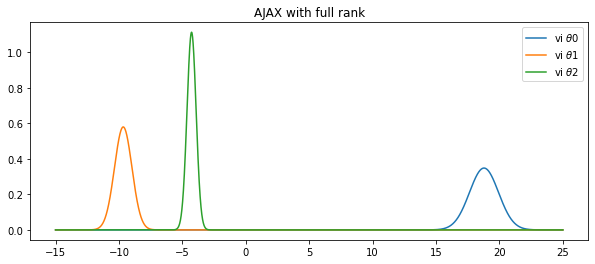

In [21]:
plt.rcParams["figure.figsize"] = (10,4)
fig, (ax1) = plt.subplots(1,1)
x = jnp.linspace(-15,25,10000)
for i in range(3):
    print(scale[i][i])
    ax1.plot(x, tfd.Normal(loc = loc_m[i],scale = jnp.sqrt(scale[i][i])).prob(x), label = r"vi $\theta$"+str(i))
ax1.set_title("AJAX with full rank")
ax1.legend()

In [22]:
variational = Variational(
    prior=prior,
    bijectors={"beta":tfb.Identity()},
    vi_type="mean_field"
)

In [23]:
advi = ADVI(prior, likelihood, variational, Y)

In [24]:
params = variational.get_params()
tx = optax.adam(learning_rate=0.1)
state = tx.init(params)
value_and_grad_fun = jax.jit(jax.value_and_grad(advi.loss),static_argnames=['n_samples'])
seed = jax.random.PRNGKey(10)
value_and_grad_fun(params, seed)

(DeviceArray(1467.177, dtype=float32),
 {'beta': <tfp.distributions.TransformedDistribution 'identityMultivariateNormalDiag' batch_shape=[] event_shape=[3] dtype=float32>})

In [25]:
def update_func(carry,x):
  params = carry['params']
  state = carry['state']
  seed = carry['seed']
  seed = jax.random.split(seed, 1)[0]
  loss, grads = value_and_grad_fun(params, seed = seed,n_samples = 10)
  updates, state = tx.update(grads, state)
  loc_m, scale = jax.tree_leaves(variational.transform_dist(params['beta']))
  params = optax.apply_updates(params, updates)
  carry = {'params':params, 'state':state, 'seed':seed}
  di = {"scale":scale, "loc" : loc_m, "loss" : loss,'grads':grads}
  return carry, di

In [26]:
carry = {'params':params, 'state': state,'seed':jax.random.PRNGKey(5)}
n_itr = 600
carry,loss = jax.lax.scan(update_func, carry,xs = None,length = n_itr)

In [27]:
variational.set_params(carry['params'])

In [28]:
loc_m, scale = jax.tree_leaves(variational.transform_dist(carry['params']['beta']))
scale,loc_m

(DeviceArray([0.22388707, 0.22115716, 0.13090336], dtype=float32),
 DeviceArray([17.636656 , -9.019957 , -4.0580244], dtype=float32))

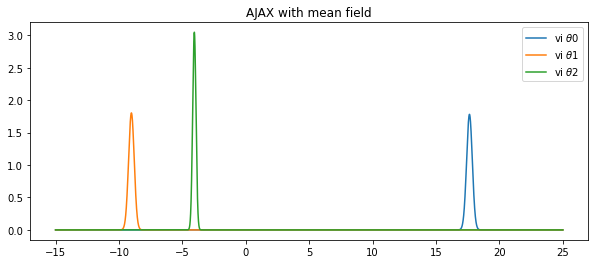

In [29]:
plt.rcParams["figure.figsize"] = (10,4)
fig, (ax1) = plt.subplots(1,1)
x = jnp.linspace(-15,25,10000)
samples = variational.sample(seed = jax.random.PRNGKey(12),sample_shape = (190000,))
for i in range(3):
    ax1.plot(x, tfd.Normal(loc = loc_m[i],scale = (scale[i])).prob(x), label = r"vi $\theta$"+str(i))
#ax1.legend()
ax1.set_title("AJAX with mean field")
ax1.legend()